## Init and Run GMM

In [1]:
%%javascript
Jupyter.utils.load_extensions('tdb_ext/main')

<IPython.core.display.Javascript object>

In [2]:
#this sets the backend to jupyter/ipython that (i think) displays
#     images directly. anyway, it prevents the matplotlib framework
#     python error that is my least favorite thing eeeevvvveeeer.
%matplotlib notebook

import sys
sys.path.append("..")

import gmix_model as gmix
import numpy as np
import tdb as tdb
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import gmix_sample_mixture as smpl

import os
os.chdir('/Users/azane/GitRepo/spider')

In [3]:
#read in training and test data
s_x, s_t = gmix.get_xt_from_npz('data/spi_gmix_train.npz', True)
t_x, t_t = gmix.get_xt_from_npz('data/spi_gmix_test.npz', True)

#TEMP
#expand target dimension so variance can be happy.
scaleOut = 100
s_t *= scaleOut
t_t *= scaleOut

In [4]:
#create gmm with data
gmm = gmix.GaussianMixtureModel(s_x, s_t, t_x, t_t,
                               numGaussianComponents=5, hiddenLayerSize=10,
                               learningRate=0.005) #0.005 worked for 2d

In [15]:
%%capture
#d will be a dictionary of evaluated tensors under their standard name.
runTimes = 500
reports = 10
assert reports>=1

gmm.train(iterations=runTimes, testBatchSize=1000,
          trainBatchSize=5000, reportEvery=int(runTimes/reports))


## Debugging

In [6]:
def scale(x, y, low, high, i=-1):
    """takes two 2d arrays, but only checks the last y column."""
    indices = np.where((y[:,i] >= low) & (y[:,i] <= high))
    return x[indices], y[indices]

In [7]:
def init4d(x, y, yLow, yHigh):
    """Takes two 2d arrays, but only graphs the first three x's, and the last y."""
    
    assert y.ndim == 2
    assert y.shape[1] == 1
    assert x.ndim == 2
    
    #exclude points outside of low/high range
    x, y = scale(x, y, yLow, yHigh)
    
    x = np.squeeze(x.transpose())
    y = np.squeeze(y[:,0])
    
    assert y.ndim == 1
    assert x.ndim == 2
    assert x.shape[0] == 3
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d') #create subplot in figure.
    
    #set the color map to the output dimension.
    scatPlot = ax.scatter(x[0], x[1], x[2], c=y) #create plot
    
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_zlabel("x3")
    
    #add colorbar label
    cb = fig.colorbar(scatPlot)
    cb.set_label("y")
    
    return fig, scatPlot

<IPython.core.display.Javascript object>


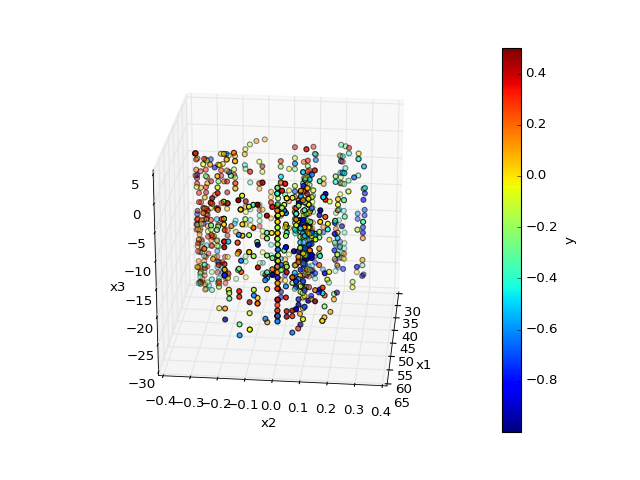

(<matplotlib.figure.Figure at 0x1458ef410>,
 <mpl_toolkits.mplot3d.art3d.Path3DCollection at 0x11473b190>)

In [18]:
m, v, u = gmm.get_xmvu()
x, y = smpl.sample_mixture(t_x, m, v, u) #set to gmm sample
#x = t_x; y = t_t #set to actual values

#cull data to a set number of points.
lim = 1000
if x.shape[0] > lim:
    randRows = np.random.randint(x.shape[0],size=lim)
    x = x[randRows]
    y = y[randRows]

init4d(x, y, yLow=-0.01*scaleOut, yHigh=0.005*scaleOut)

In [9]:
evalStr = [
        'calc_agg_grad_w1',
        'calc_agg_grad_b1',
        'calc_agg_grad_w2',
        'calc_agg_grad_b2',
        'calc_agg_grad_w3',
        'calc_agg_grad_b3',
        
        'v'
    ]
d = gmm.get_evals(evalStr)

In [10]:
#%%capture
print 'calc_agg_grad_w1'
print d['calc_agg_grad_w1']
print 'calc_agg_grad_b1'
print d['calc_agg_grad_b1']
print 'calc_agg_grad_w2'
print d['calc_agg_grad_w2']
print 'calc_agg_grad_b2'
print d['calc_agg_grad_b2']
print 'calc_agg_grad_w3'
print d['calc_agg_grad_w3']
print 'calc_agg_grad_b3'
print d['calc_agg_grad_b3']

calc_agg_grad_w1
[[  4.67451318e-05  -6.59662182e-04   1.68515529e-04   2.14480999e-04
   -7.53517204e-04   1.72003653e-04   1.96374589e-04   7.95396409e-05
   -1.72985820e-04   5.98838611e-04]
 [ -1.19730110e-04   5.71377692e-04  -2.73415480e-06  -1.32986112e-04
    1.67072008e-04   3.34681012e-04   3.09789699e-04   1.07781321e-04
    3.33910488e-04   3.48088826e-04]
 [  6.74055947e-04   1.20646779e-04  -2.92869256e-04  -4.13859700e-04
    4.23568097e-04  -4.82191186e-04  -1.10157568e-03   5.74900478e-04
    6.27760659e-04  -6.25880086e-04]]
calc_agg_grad_b1
[  6.68112698e-05  -1.79544266e-04  -5.98554092e-04  -5.92419936e-04
   7.70566228e-04  -1.36007846e-03   4.44853737e-04  -2.08441634e-04
   2.63589405e-04  -3.33934615e-04]
calc_agg_grad_w2
[[ -8.87536371e-05  -2.77991261e-04  -3.29549715e-04   6.45572669e-04
   -5.66357230e-05   1.70676925e-04  -3.06329690e-04  -1.28532731e-04
    2.33472820e-04  -3.04608875e-05]
 [  3.38952377e-04   1.02180475e-03  -4.75250301e-04  -7.76738103e

In [11]:
print d['v']

[[ 0.21839948]
 [ 0.22452939]
 [ 0.23813076]
 ..., 
 [ 0.36767697]
 [ 0.36722544]
 [ 0.36742395]]
